# 주가 예측 모델 구축

## 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

In [3]:
esgu = pd.read_csv('../데이터셋/ESGU.csv', encoding='cp949')
erth = pd.read_csv('../데이터셋/^GSPC.csv', encoding='cp949')
vde = pd.read_csv('../데이터셋/VDE.csv', encoding='cp949')
nulg = pd.read_csv('../데이터셋/NULG.csv', encoding='cp949')
tan = pd.read_csv('../데이터셋/TAN.csv', encoding='cp949')
susa = pd.read_csv('../데이터셋/SUSA.csv', encoding='cp949')

# 전통 에너지 관련 주가 데이터
xom = pd.read_csv('../데이터셋/XOM.csv')
eog = pd.read_csv('../데이터셋/EOG.csv')
mpc = pd.read_csv('../데이터셋/MPC.csv')
kmi = pd.read_csv('../데이터셋/KMI.csv')
btu = pd.read_csv('../데이터셋/BTU.csv')

# 친환경 에너지 관련 주가 데이터
nee = pd.read_csv('../데이터셋/NEE.csv')
fslr = pd.read_csv('../데이터셋/FSLR.csv')
enph = pd.read_csv('../데이터셋/ENPH.csv')
run = pd.read_csv('../데이터셋/RUN.csv')

## 2. 뉴스 감성 점수 병합

In [4]:
# 뉴스 감성 점수 데이터 로드 (이전에 감성 분석한 결과)
news_df = pd.read_csv("../데이터셋/news_sentiment_analysis.csv")

# 날짜 정리
news_df['Date'] = pd.to_datetime(news_df['Date'])

# 날짜별 평균 감성 점수 계산
news_sentiment = news_df.groupby('Date')['Sentiment_Score'].mean().reset_index()


## 3. 전처리

In [5]:
def stock_pre(df):
    # 7번째 행 삭제
    df.drop(df.columns[6], axis=1, inplace=True)
    # 열 이름 통일
    new_columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume']
    df.columns = new_columns
    # 날짜로 정렬
    df.sort_values('Date',ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['Date'] = pd.to_datetime(df['Date'])  # 날짜 형식 변환
    df = df.merge(news_sentiment, on='Date', how='left')  # 새로운 데이터프레임이 생성되지만, 원본은 변경되지 않음
    df['Sentiment_Score'].fillna(0, inplace=True)

    # 시작 날짜와 종료 날짜를 설정
    start = '2016-01-01'
    end = '2025-02-01'

    # 이 기간 동안의 데이터만 필터링
    df = df[(df['Date'] >= start) & (df['Date'] <= end)]
    
    df.index = df["Date"]
    df.drop("Date", axis = 1, inplace = True)
    df
    # 이동평균과 이격도 변수 추가
    period = [5, 20, 60, 120]

    for p in period :
        df[f"{p}MA"] = df["Close"].rolling(window = p).mean()
        df[f"{p}Disparity"] = df["Close"] / df[f"{p}MA"]

    # bfill로 결측값 채우기
    df.bfill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    # ffill로 결측값 채우기
    df.ffill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    return df

In [6]:
nulg = stock_pre(nulg)

## 4. 모델

In [7]:
TARGET = "Close"
SEQ_SIZE = 50
PRED_SIZE = 1
EPOCH = 30
BATCH_SIZE = 32

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(nulg, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)


[[ 2.18514938e+01  2.18514938e+01  2.18514938e+01  2.18514938e+01
   0.00000000e+00  0.00000000e+00  2.18404053e+01  9.99873073e-01
   2.19410148e+01  1.00911158e+00  2.25368405e+01  1.04445490e+00
   2.33289388e+01  1.06277926e+00]
 [ 2.18376331e+01  2.18462974e+01  2.18203013e+01  2.18376331e+01
   6.00000000e+02  5.17575383e-01  2.18404053e+01  9.99873073e-01
   2.19410148e+01  1.00911158e+00  2.25368405e+01  1.04445490e+00
   2.33289388e+01  1.06277926e+00]
 [ 2.18376331e+01  2.18376331e+01  2.18376331e+01  2.18376331e+01
   1.00000000e+02  0.00000000e+00  2.18404053e+01  9.99873073e-01
   2.19410148e+01  1.00911158e+00  2.25368405e+01  1.04445490e+00
   2.33289388e+01  1.06277926e+00]
 [ 2.18376331e+01  2.18376331e+01  2.18376331e+01  2.18376331e+01
   0.00000000e+00  0.00000000e+00  2.18404053e+01  9.99873073e-01
   2.19410148e+01  1.00911158e+00  2.25368405e+01  1.04445490e+00
   2.33289388e+01  1.06277926e+00]
 [ 2.18376331e+01  2.18376331e+01  2.18376331e+01  2.18376331e+01
  

In [8]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)


### 4.1 GRU

In [9]:
# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.2232 - val_loss: 0.1615
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1234 - val_loss: 0.1533
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1150 - val_loss: 0.1499
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0951 - val_loss: 0.1091
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0901 - val_loss: 0.1206
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0815 - val_loss: 0.0925
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0773 - val_loss: 0.0866
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0714 - val_loss: 0.0651
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0647 - val_loss: 0.0608
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0598 - val_loss: 0.0505
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0575 - val_loss: 0.0501
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0

In [10]:
# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')


MSE: 0.0019872919600163984
MAE: 0.0397881877727639


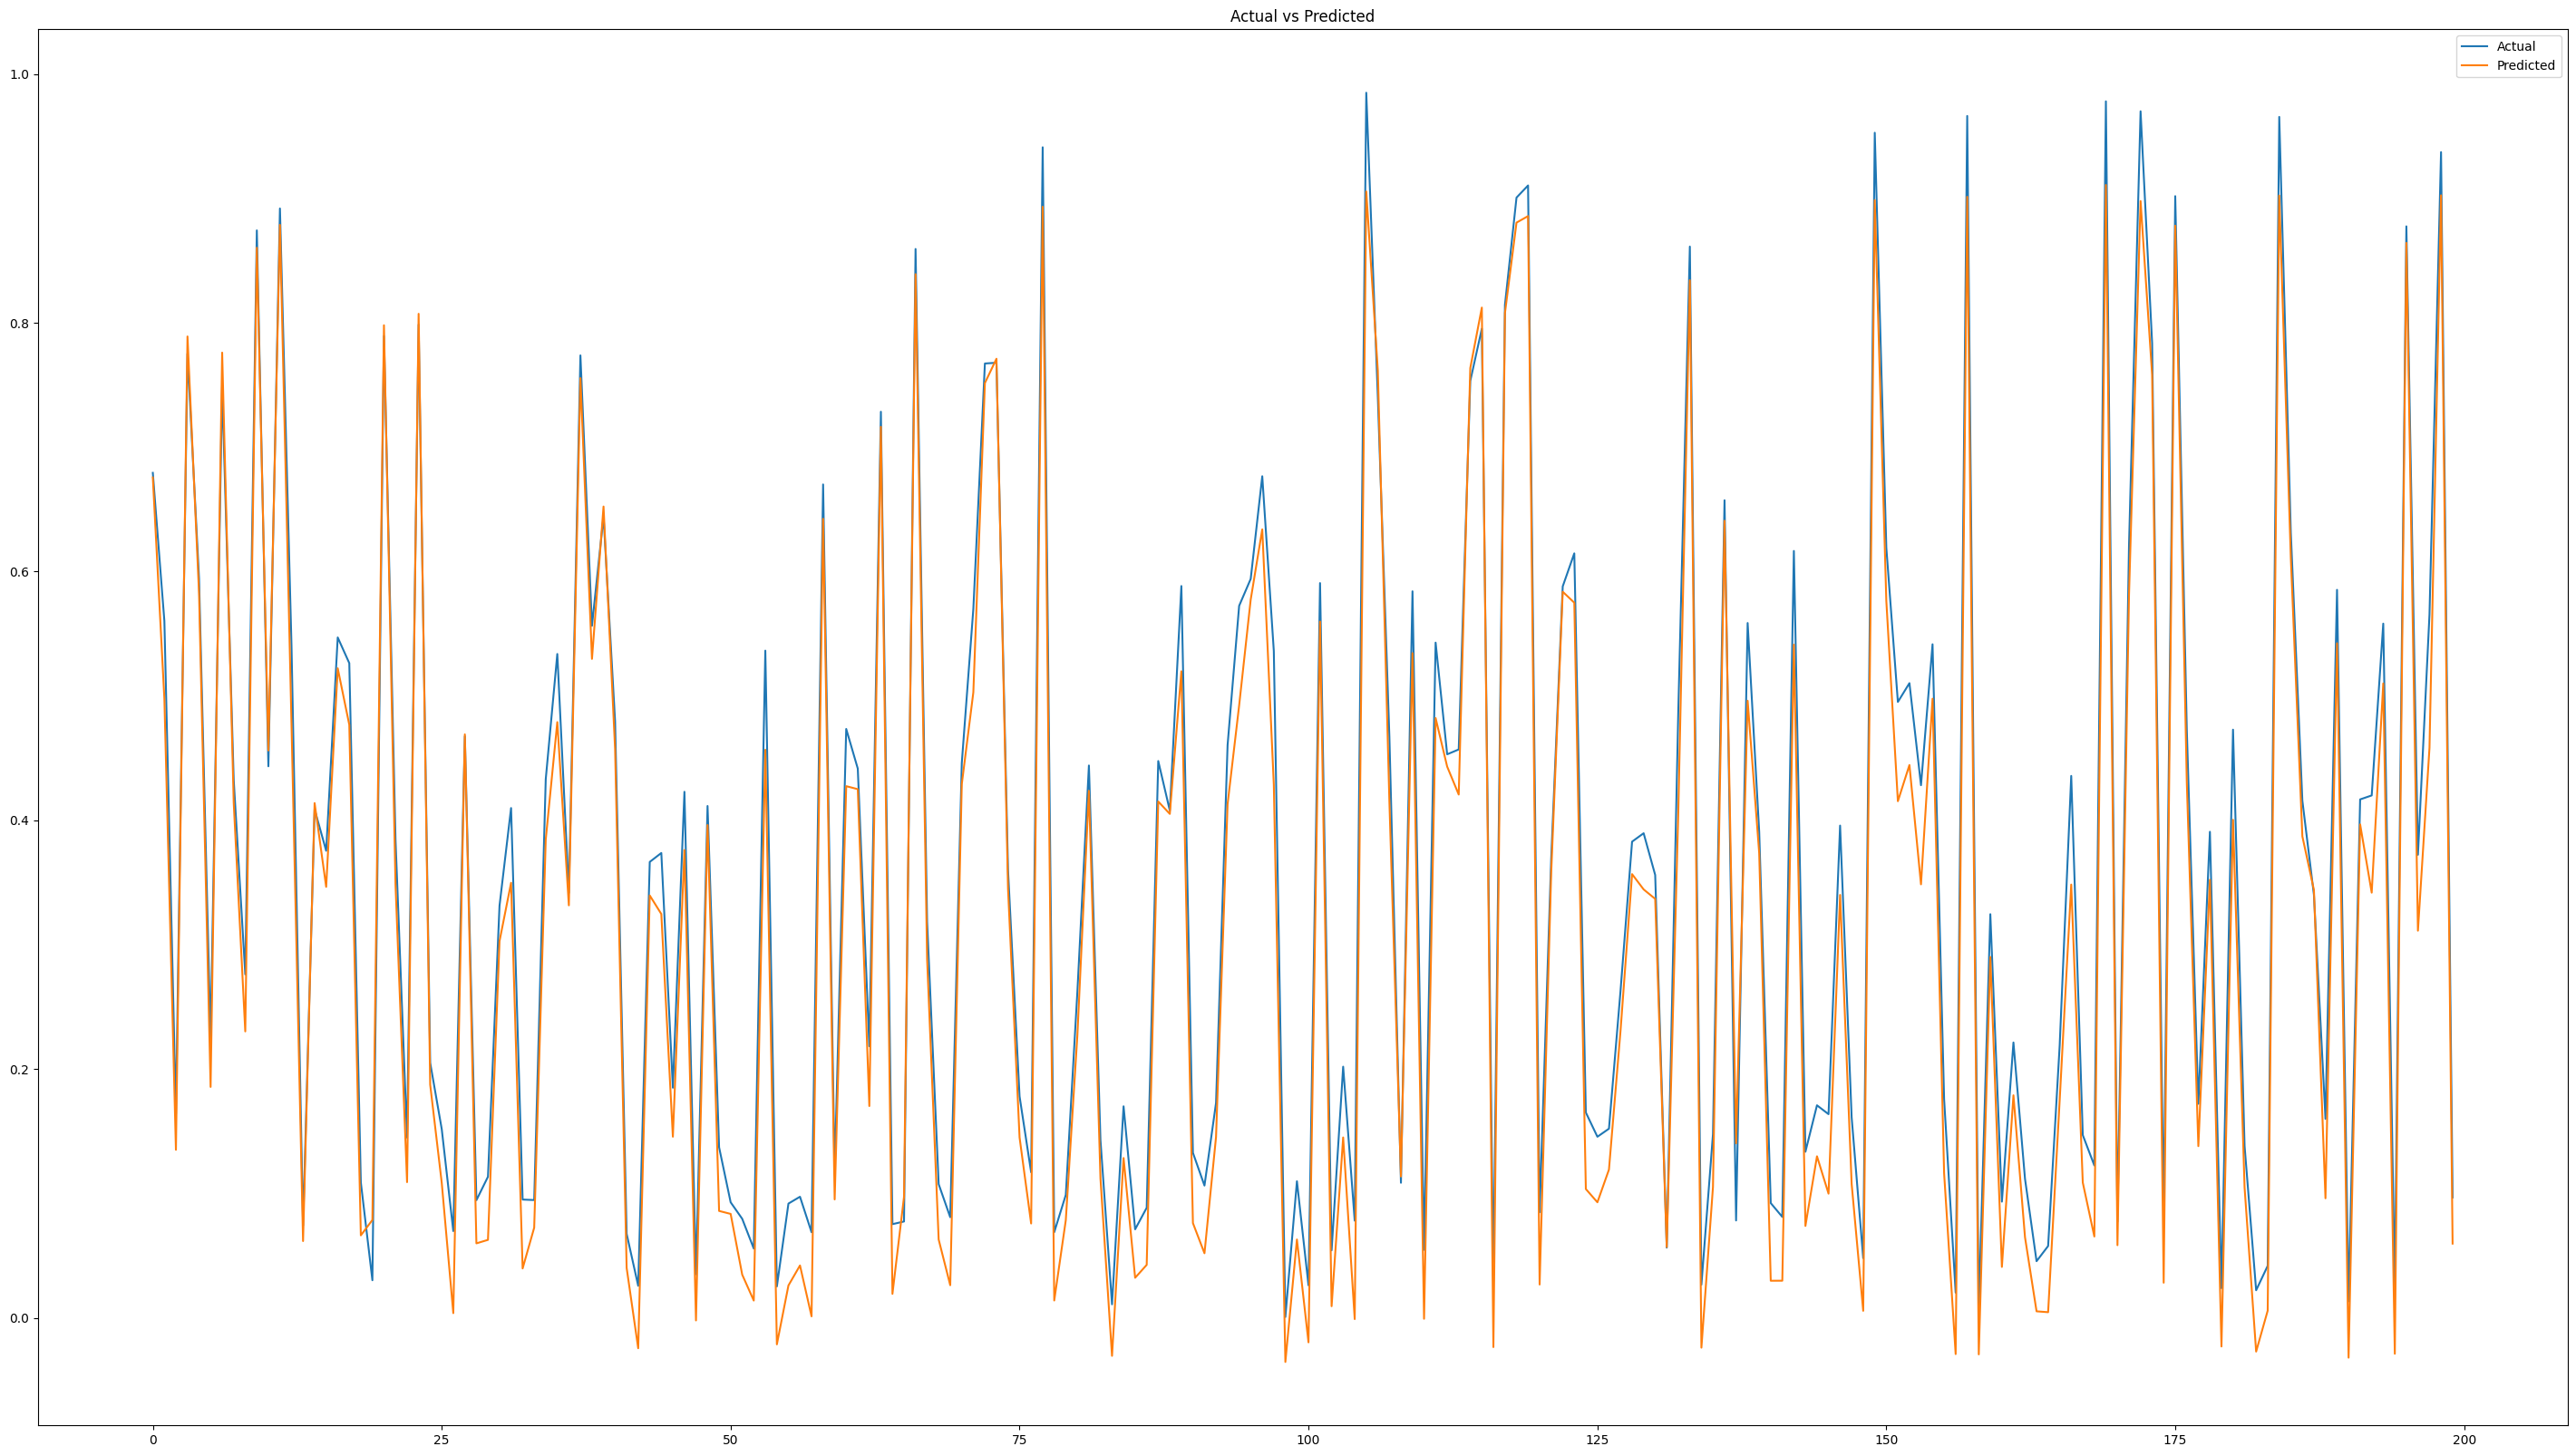

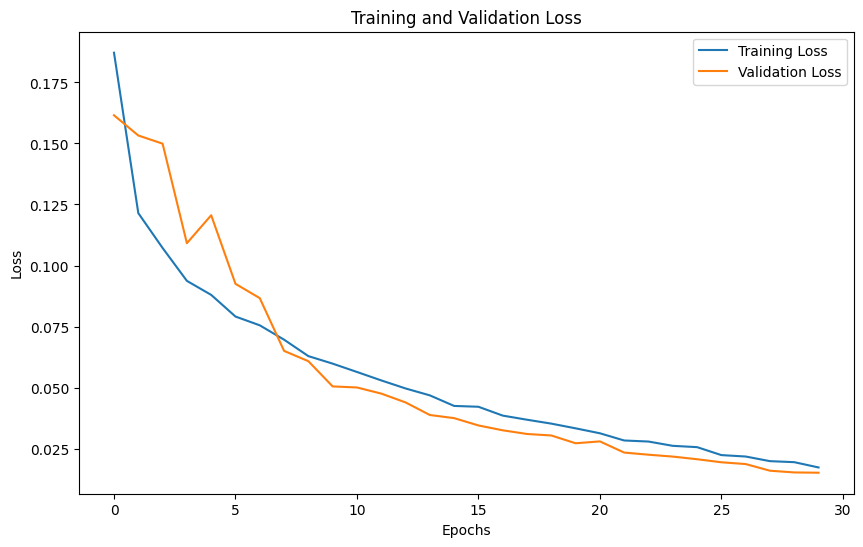

In [11]:
# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test[100:300].flatten(), label='Actual')
plt.plot(y_pred[100:300].flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### 4.2 LSTM

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.1220 - val_loss: 0.0715
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0691 - val_loss: 0.0571
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0542 - val_loss: 0.0434
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0415 - val_loss: 0.0326
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0322 - val_loss: 0.0252
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0251 - val_loss: 0.0213
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0198 - val_loss: 0.0152
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0164 - val_loss: 0.0121
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0126 - val_loss: 0.0108
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0

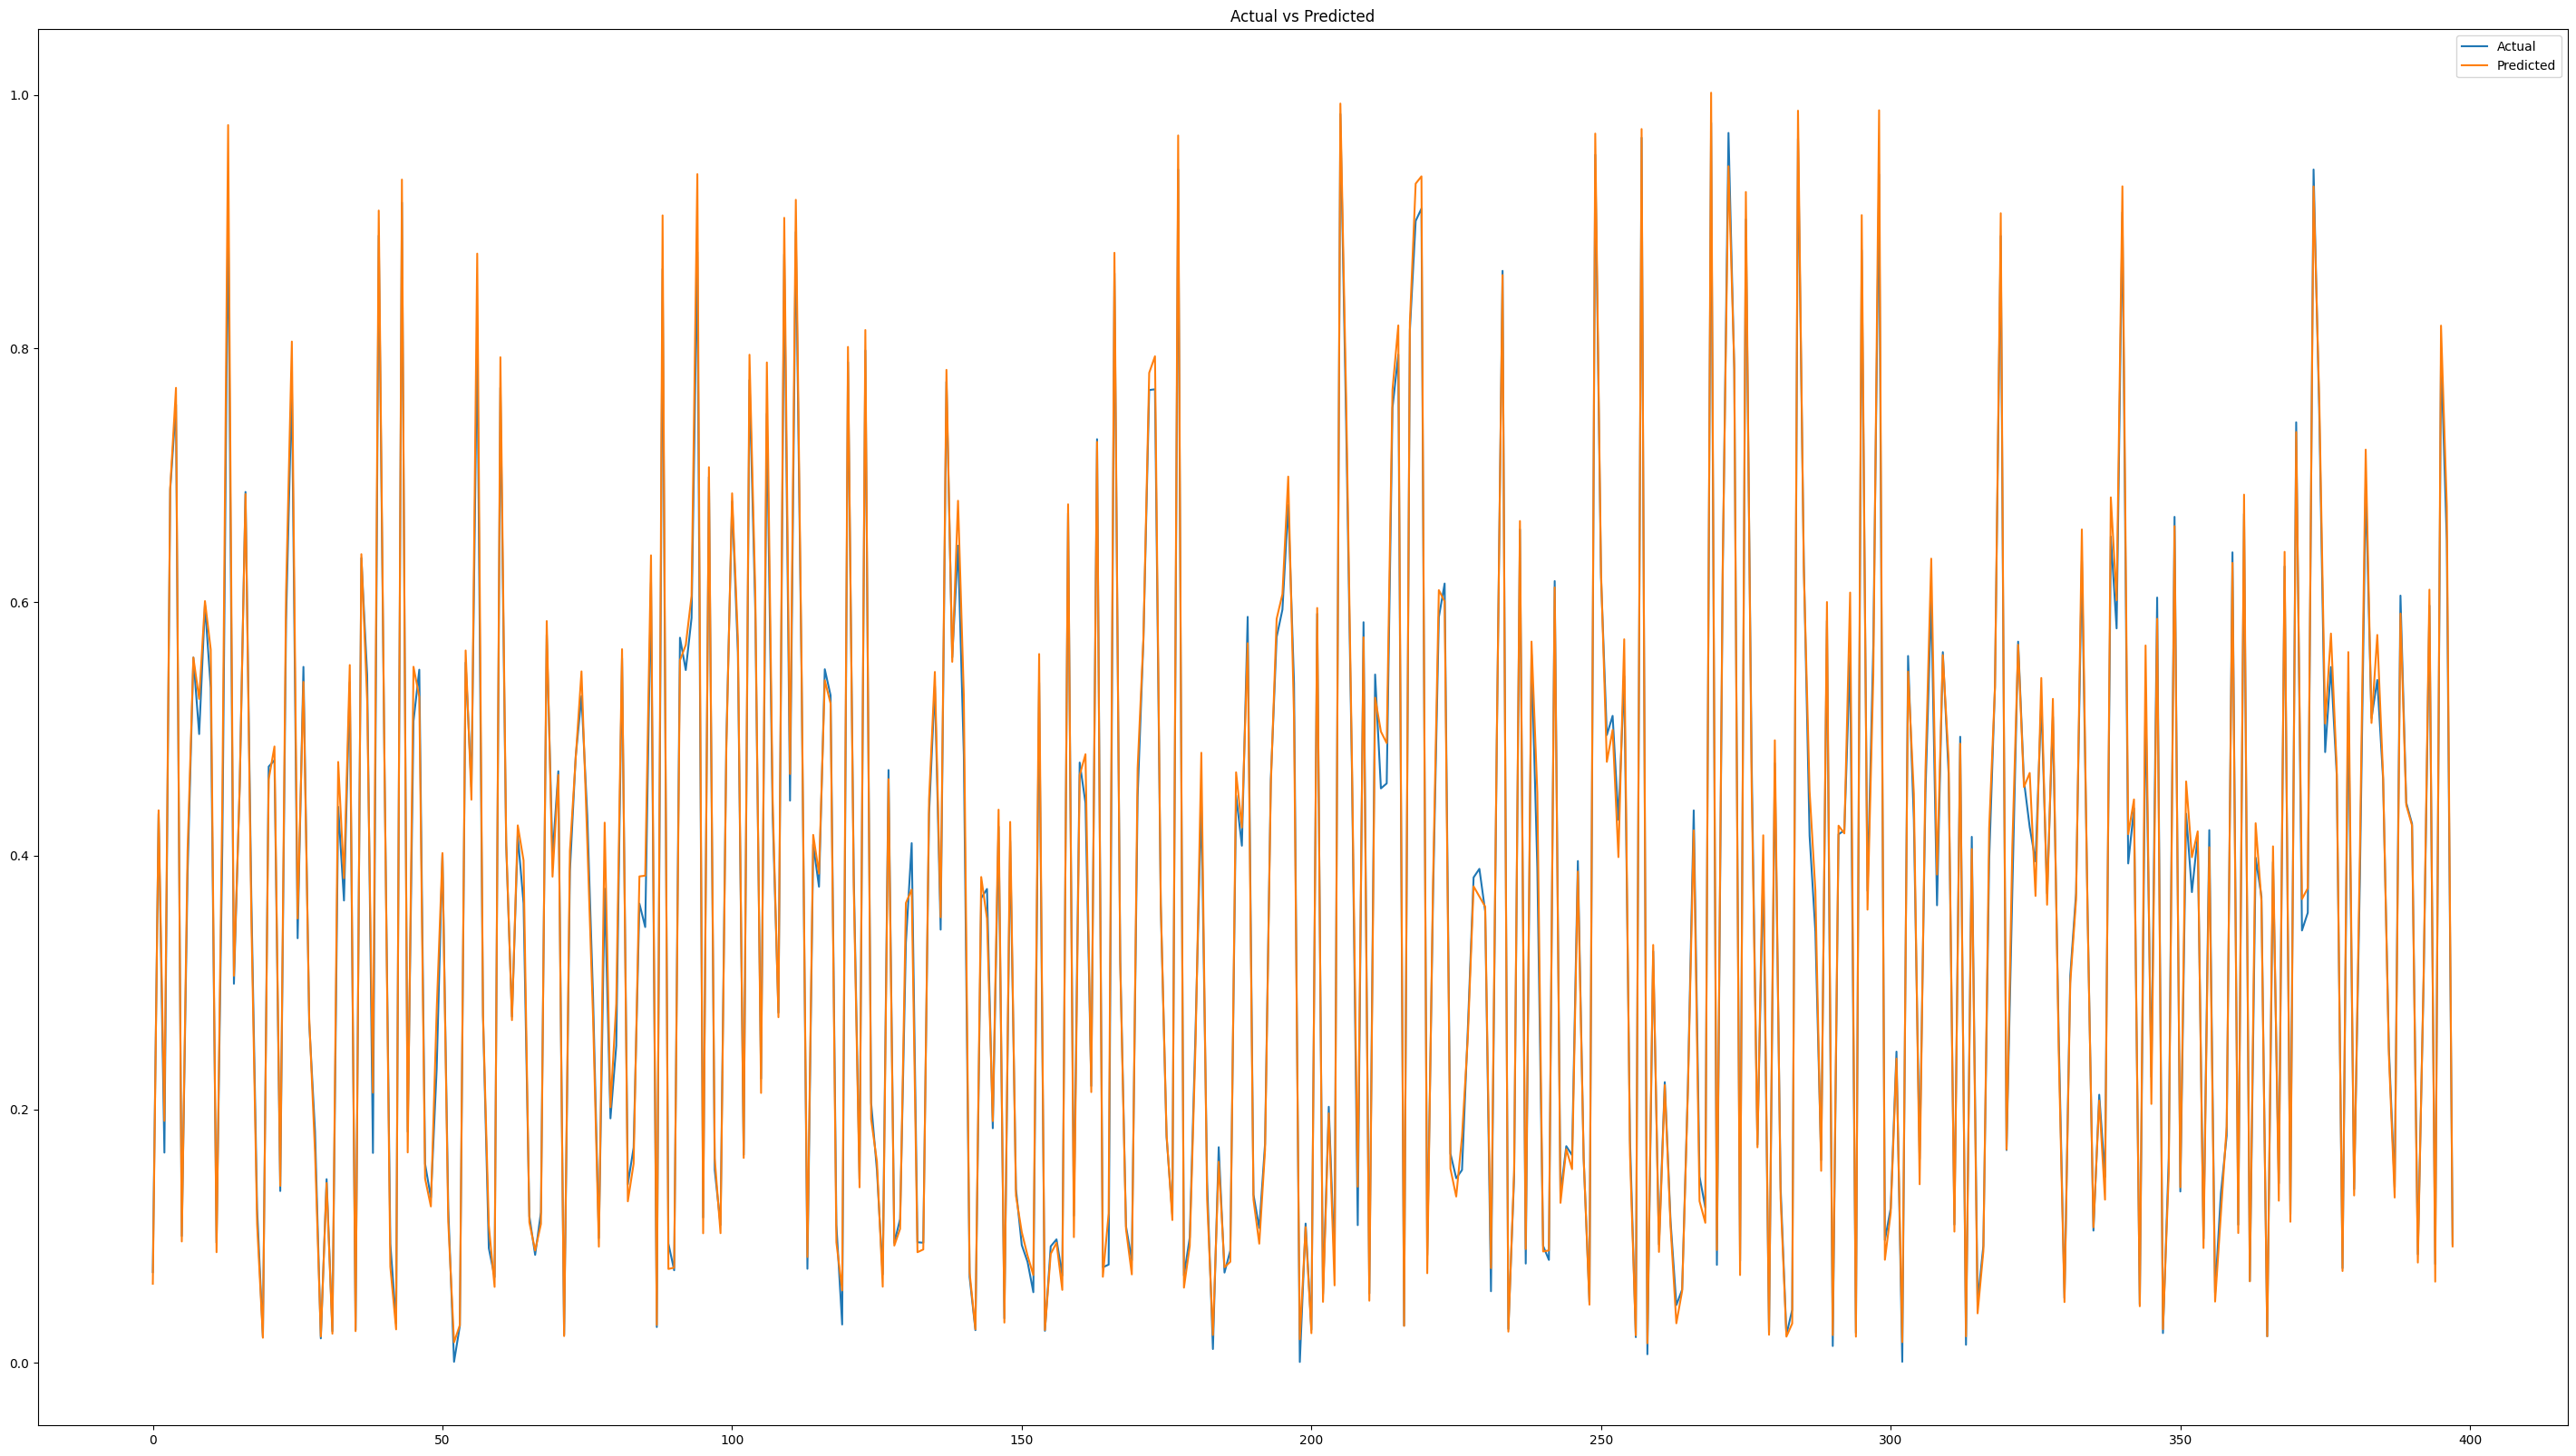

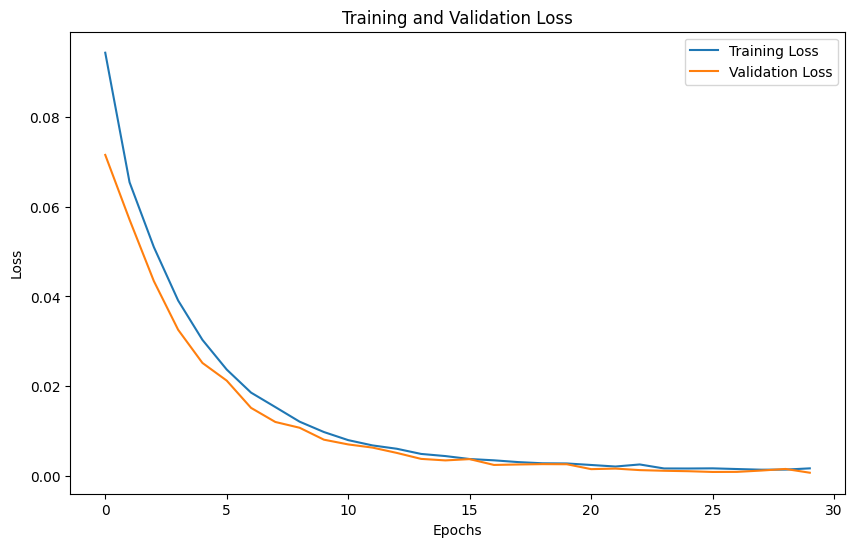

In [12]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)
from tensorflow.keras import regularizers


# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model2 = Sequential()
model2.add(LSTM(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model2.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model2.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model2.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model2.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()